# Philippine Evacuation Centers Dataset
Evacuation Centers and Shelters Dataset in the Philippines. In all honesty, I made this dataset to finish a school project and I wondered why is there no central dataset for evacuation centers in the Philippines. With this being said, I publish this dataset to the public to help others who might need it.

## Import Statements
Before we progress further, let us first import necessary libraries and packages that would help us in the further sections of this notebook.

In [44]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

from pathlib import Path

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Getting the Dataset
I tried looking for it in Kaggle but I found none. Since there is no central repository yet of all Evacuation Centers in the Philippines to download, I decided to manually collect them. But this task was made easy because of the Overpass Turbo API.


### Querying in Overpass Turbo
The evacuation center dataset was retrieved using the [Overpass Turbo API](https://overpass-turbo.eu/) with the following query:

<div class="alert alert-block alert-info">
<b>Info:</b> I used Philippine Mapping Conventions in creating the query. You may view them <a href="https://wiki.openstreetmap.org/wiki/Philippines/Mapping_conventions">here.</a>
</div>

```
[out:json][timeout:25];

{{geocodeArea:Philippines}}->.searchArea;
(
  node["social_facility"="shelter"](area.searchArea);
  way["social_facility"="shelter"](area.searchArea);
  relation["social_facility"="shelter"](area.searchArea);
  
  node["social_facility:for"="displaced"](area.searchArea);
  way["social_facility:for"="displaced"](area.searchArea);
  relation["social_facility:for"="displaced"](area.searchArea);
  
  node["emergency:social_facility"="shelter"](area.searchArea);
  way["emergency:social_facility"="shelter"](area.searchArea);
  relation["emergency:social_facility"="shelter"](area.searchArea);
  
  node["emergency:social_facility:for"="displaced"](area.searchArea);
  way["emergency:social_facility:for"="displaced"](area.searchArea);
  relation["emergency:social_facility:for"="displaced"](area.searchArea);
);

out body;
>;
out skel qt;
```
After querying, I then proceeded to export the data into a `.geojson` file. We shall access this now using GeoPandas. Let's load that file below.

In [48]:
ph_evacs = gpd.read_file("data/ph_evacs_raw.geojson")
ph_evacs.head(3)

,id,@id,@relations,FIXME,Notes,access,activation,addr2:street,addr3:street,addr:barangay,...,typhoon:damage,wall:material,was:amenity,water_source,website,wheelchair,wikidata,wikimedia_commons,wikipedia,geometry
0,relation/2931366,relation/2931366,None,None,None,None,None,None,None,Palico IV,...,None,None,None,None,None,None,None,None,None,"POLYGON ((120.94575 14.42849, 120.94563 14.428..."
1,relation/6028843,relation/6028843,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,"POLYGON ((126.00152 7.96686, 126.00164 7.96704..."
2,relation/8814264,relation/8814264,None,None,None,None,None,None,None,None,...,None,None,None,None,None,yes,None,None,None,"POLYGON ((120.86813 14.28636, 120.86893 14.286..."


# Exploring and Cleaning
One of the most tedious part of the job but might be the most important step out of them all. We need to spend more time cleaning since we just queried the data from Overpass Turbo.

### Inspecting Columns
We are currently working with 210 columns with this DataFrame. Our first step will be dropping some columns and retaining relevant pieces of information. Let's list first the columns and work our way from there.

In [59]:
ph_evacs.columns.to_list()

['id',
 '@id',
 '@relations',
 'FIXME',
 'Notes',
 'access',
 'activation',
 'addr2:street',
 'addr3:street',
 'addr:barangay',
 'addr:borough',
 'addr:city',
 'addr:country',
 'addr:district',
 'addr:floor',
 'addr:full',
 'addr:hamlet',
 'addr:housename',
 'addr:housenumber',
 'addr:island',
 'addr:municipality',
 'addr:neighbourhood',
 'addr:place',
 'addr:postcode',
 'addr:province',
 'addr:quarter',
 'addr:state',
 'addr:street',
 'addr:street:corner',
 'addr:subdistrict',
 'addr:suburb',
 'addr:town',
 'addr:village',
 'addr:zip',
 'admin_level',
 'air_conditioning',
 'alt_name',
 'amenity',
 'architect',
 'area',
 'assembly_point:flood',
 'baby_hatch',
 'backboards:material',
 'backboards:shape',
 'backboards:size',
 'backup_generator',
 'barrier',
 'branch',
 'building',
 'building:levels',
 'building:material',
 'building:part',
 'capacity',
 'capacity:2013',
 'capacity:emergency',
 'capacity:persons',
 'check_date',
 'community_centre',
 'construction',
 'construction:amenity

Before manipulating the data, we'll copy the original `gdf` first so that we can go back anytime to the original data.

In [60]:
ph_evacs_copy = ph_evacs.copy()

This portion is arbitrary but since we have many columns, we'll just choose the columns to be dropped (immediately) if their values are `1/4` of the original rows.

<div class="alert alert-block alert-info">
<b>Info:</b> The 1/4 in the equation is arbitrary. It can be changed. Since there are 1676 rows, if there are less than 419 entries, we'll automatically add them to the columns to be dropped.
</div>

In [61]:
# All columns of ph_evacs_copy that has values less than total rows of our original DataFrame
less_than_shape = []
for col in ph_evacs_copy.columns:
  if ph_evacs_copy[col].value_counts().shape[0] < (ph_evacs_copy.shape[0] / 4):
    less_than_shape.append(col)

less_than_shape

['@relations',
 'FIXME',
 'Notes',
 'access',
 'activation',
 'addr2:street',
 'addr3:street',
 'addr:barangay',
 'addr:borough',
 'addr:city',
 'addr:country',
 'addr:district',
 'addr:floor',
 'addr:full',
 'addr:hamlet',
 'addr:housename',
 'addr:housenumber',
 'addr:island',
 'addr:municipality',
 'addr:neighbourhood',
 'addr:place',
 'addr:postcode',
 'addr:province',
 'addr:quarter',
 'addr:state',
 'addr:street',
 'addr:street:corner',
 'addr:subdistrict',
 'addr:suburb',
 'addr:town',
 'addr:village',
 'addr:zip',
 'admin_level',
 'air_conditioning',
 'alt_name',
 'amenity',
 'architect',
 'area',
 'assembly_point:flood',
 'baby_hatch',
 'backboards:material',
 'backboards:shape',
 'backboards:size',
 'backup_generator',
 'barrier',
 'branch',
 'building',
 'building:levels',
 'building:material',
 'building:part',
 'capacity',
 'capacity:2013',
 'capacity:emergency',
 'capacity:persons',
 'check_date',
 'community_centre',
 'construction',
 'construction:amenity',
 'constructi

Let's add '@id' since it's a duplicate of the column 'id'.

In [62]:
less_than_shape.append('@id')

Let's remove the following columns in the list of columns to be removed:
- 'addr:municipality'
- 'addr:city'
- 'addr:place'
- 'addr:provice'
- 'addr:state'
- 'amenity'
- 'leisure'
- 'capacity:persons'
- 'official_name',
- 'old_name',

These columns appear to be important for us when displaying information about the evacuation centers.

In [63]:
less_than_shape = [x for x in less_than_shape if x not in ['addr:city', 'addr:municipality', 'addr:place', 'addr:province', 'addr:state', 'amenity', 'leisure', 'capacity:persons', 'official_name', 'old_name']]

### Dropping Irrelevant Columns
Since we are done with listig irrelevant columns, we are now ready to drop them.

In [64]:
ph_evacs_copy.drop(columns=less_than_shape, inplace=True)
ph_evacs_copy.head(3)

,id,addr:city,addr:municipality,addr:place,addr:province,addr:state,amenity,capacity:persons,leisure,name,official_name,old_name,geometry
0,relation/2931366,None,None,None,Cavite,None,school,None,None,General Emilio Aguinaldo National High School,None,Imus High Schoo,"POLYGON ((120.94575 14.42849, 120.94563 14.428..."
1,relation/6028843,None,None,Purok 2,Agusan del Sur,None,school,None,None,San Pascual Elementary School,None,None,"POLYGON ((126.00152 7.96686, 126.00164 7.96704..."
2,relation/8814264,Trece Martires,None,San Agustin,Cavite,None,school,None,None,Trece Martires City Elementary School,None,None,"POLYGON ((120.86813 14.28636, 120.86893 14.286..."


### Cleaning the ID
Upon inspection, it seems like our unique identifier has a type included. To better organize the data, let's split it and keep the number ID only.

In [65]:
# Split the id columns to id and types
ph_evacs_copy['id'] = ph_evacs_copy['id'].str.split('/').str[1]
ph_evacs_copy.head(3)

,id,addr:city,addr:municipality,addr:place,addr:province,addr:state,amenity,capacity:persons,leisure,name,official_name,old_name,geometry
0,2931366,None,None,None,Cavite,None,school,None,None,General Emilio Aguinaldo National High School,None,Imus High Schoo,"POLYGON ((120.94575 14.42849, 120.94563 14.428..."
1,6028843,None,None,Purok 2,Agusan del Sur,None,school,None,None,San Pascual Elementary School,None,None,"POLYGON ((126.00152 7.96686, 126.00164 7.96704..."
2,8814264,Trece Martires,None,San Agustin,Cavite,None,school,None,None,Trece Martires City Elementary School,None,None,"POLYGON ((120.86813 14.28636, 120.86893 14.286..."


In [66]:
ph_evacs_copy.describe()

,id,addr:city,addr:municipality,addr:place,addr:province,addr:state,amenity,capacity:persons,leisure,name,official_name,old_name,geometry
count,1676,281,20,275,442,1,1092,860,372,1549,2,43,1676
unique,1676,76,9,174,38,1,17,6,6,1412,2,43,1676
top,2931366,Dasmariñas,Rosario,Proper,Pampanga,Pampanga,school,<50,sports_centre,Evacuation Center,Sasmuan Central School,Imus High Schoo,"POLYGON ((120.9457518 14.4284889, 120.9456339 ..."
freq,1,40,10,12,171,1,416,218,252,5,1,1,1


Since the `state` column contains 1 count only, let's just drop it as it appears to be just the same as `province` as well.

In [67]:
ph_evacs_copy.drop(columns=['addr:state'], inplace=True)
ph_evacs_copy.head(3)

,id,addr:city,addr:municipality,addr:place,addr:province,amenity,capacity:persons,leisure,name,official_name,old_name,geometry
0,2931366,None,None,None,Cavite,school,None,None,General Emilio Aguinaldo National High School,None,Imus High Schoo,"POLYGON ((120.94575 14.42849, 120.94563 14.428..."
1,6028843,None,None,Purok 2,Agusan del Sur,school,None,None,San Pascual Elementary School,None,None,"POLYGON ((126.00152 7.96686, 126.00164 7.96704..."
2,8814264,Trece Martires,None,San Agustin,Cavite,school,None,None,Trece Martires City Elementary School,None,None,"POLYGON ((120.86813 14.28636, 120.86893 14.286..."


### Renaming Columns
Some of our columns have some prefixes that is better off to be removed for simplicity. Let's do that, particularly the removal of `addr:` prefixes.

In [68]:
ph_evacs_copy.rename(columns={
    'addr:state': 'state',
    'addr:province': 'province',
    'addr:place': 'place',
    'addr:city': 'city',
    'addr:municipality': 'municipality',
    'capacity:persons': 'capacity'
  }, inplace=True)

### Aggregating Data
There are some unique values in the dataset, specifically the amenity column that we can aggregate and represent with a single category. We shall implement the following categories and listed below is the current value to be changed.

**Campus**
- childcare
- school
- kindergarten
- college
- university

**Church**
- place_of_worship
- church

**Hospital**
- clinic
- health_post
- hospital

**Barangay Hall**
- community_centre
- events_venue
- marketplace
- town_hall
- police

**Shelter**
- shelter
- social_facility

In [69]:
ph_evacs_copy['amenity'] = ph_evacs_copy['amenity'].replace({
    'childcare': 'Campus',
    'school': 'Campus',
    'kindergarten': 'Campus',
    'college': 'Campus',
    'university': 'Campus',

    'place_of_worship': 'Church',
    'church': 'Church',

    'clinic': 'Hospital',
    'health_post': 'Hospital',
    'hospital': 'Hospital',

    'community_centre': 'Barangay Hall',
    'events_venue': 'Barangay Hall',
    'marketplace': 'Barangay Hall',
    'town_hall': 'Barangay Hall',
    'townhall': 'Barangay Hall',
    'police':'Barangay Hall',

    'shelter': 'Shelter',
    'social_facility': 'Shelter',
})

Next, in our list is the `leisure` column. We kept it because it still gives us valuable data as seen below after you run the code block.

In [70]:
ph_evacs_copy['leisure'].value_counts()

leisure
sports_centre    252
sports_hall       68
pitch             46
park               4
stadium            1
resort             1
Name: count, dtype: int64

We shall merge it with `amenity`. Drop `leisure`. Then finally rename `amenity` to `type`. Let's do that now.

In [71]:
# Iterate through the DataFrame and copy 'leisure' values to 'amenity' where 'leisure' is not null
for index, row in ph_evacs_copy.iterrows():
  if not pd.isnull(row['leisure']):
    ph_evacs_copy.loc[index, 'amenity'] = row['leisure']

# Drop the 'leisure' column
ph_evacs_copy.drop(columns=['leisure'], inplace=True)

# Rename properly
ph_evacs_copy['amenity'] = ph_evacs_copy['amenity'].replace({
    'sports_centre': 'Sports Center',
    'sports_hall': 'Sports Center',

    'pitch': 'Field',
    'park': 'Field',
    'resort': 'Field',

    'stadium': 'Stadium'
})

# Rename 'amenity' to 'type'
ph_evacs_copy.rename(columns={'amenity': 'type'}, inplace=True)

### Handling Missing Values
Run the following code block to inspect on the Missing Values. Upon running, It looks like we're still missing some values.

In [72]:
ph_evacs_copy[ph_evacs_copy['type'].isnull() == True]

,id,city,municipality,place,province,type,capacity,name,official_name,old_name,geometry
15,12513849,None,None,None,None,None,None,Santuario del Santo Cristo,None,None,"POLYGON ((121.03037 14.59840, 121.03004 14.598..."
38,14158363,San Juan,None,None,None,None,None,San Juan City Schools Division Office,None,None,"POLYGON ((121.02885 14.60408, 121.02956 14.604..."
52,16711683,None,None,None,None,None,None,Saint John the Baptist Parish,None,None,"POLYGON ((121.02864 14.60492, 121.02854 14.604..."
55,17253858,None,None,None,None,None,None,CASS Building,None,None,"MULTIPOLYGON (((124.24298 8.24007, 124.24318 8..."
57,17632993,Dasmariñas,None,None,Cavite,None,None,Dasmariñas Evacuation Shelter,None,None,"POLYGON ((120.94702 14.25291, 120.94702 14.252..."
...,...,...,...,...,...,...,...,...,...,...,...
1649,8332489726,None,None,None,None,None,50-100,Mabuanbuan Secondary Evacuation Center,None,None,POINT (120.60147 14.82996)
1657,9611967593,None,None,None,None,None,None,Del Rosario Evacuation Center,None,None,POINT (123.75216 12.98632)
1658,9611967610,None,None,None,None,None,None,Putiao Evacuation Center,None,None,POINT (123.71278 13.02033)
1672,11276469991,None,None,Purok 1,None,None,100-250,New Baluan Barangay Hall,None,None,POINT (124.37516 6.33855)


It appears that there some rows where the `type`, `name`, `official_name`, and `old_name` are all missing. Since we don't have much information about them, let's just drop them.

In [73]:
ph_evacs_copy.dropna(subset=['type', 'name', 'official_name', 'old_name'], how='all', inplace=True)

Now that we have ensured that we would have a name either from the `name`, `official_name`, or `old_name`. Let's use those columns to fix the remaining ones.

We will implement a rule and be naive by assuming that if the name appears to have a certain keyword, we automatically categorized it to our main ones. The following are the rules:

In [74]:
for index, row in ph_evacs_copy.iterrows():

  if 'Church' in str(row['name']):
    ph_evacs_copy.loc[index, 'type'] = 'Church'
  elif 'Parish' in str(row['name']):
    ph_evacs_copy.loc[index, 'type'] = 'Church'
  elif 'Santuario' in str(row['name']):
    ph_evacs_copy.loc[index, 'type'] = 'Church'
  elif 'Cristo' in str(row['name']):
    ph_evacs_copy.loc[index, 'type'] = 'Church'
  elif 'Chapel' in str(row['name']):
    ph_evacs_copy.loc[index, 'type'] = 'Church'

  elif 'Medical' in str(row['name']):
    ph_evacs_copy.loc[index, 'type'] = 'Hospital'

  elif 'Schools' in str(row['name']):
    ph_evacs_copy.loc[index, 'type'] = 'Campus'
  elif 'Elementary' in str(row['name']):
    ph_evacs_copy.loc[index, 'type'] = 'Campus'
  elif 'Day Care' in str(row['name']):
    ph_evacs_copy.loc[index, 'type'] = 'Campus'
  elif 'CASS' in str(row['name']):
    ph_evacs_copy.loc[index, 'type'] = 'Campus'
  elif 'Academy' in str(row['name']):
    ph_evacs_copy.loc[index, 'type'] = 'Campus'

  elif 'Pambarangay' in str(row['name']):
    ph_evacs_copy.loc[index, 'type'] = 'Barangay Hall'
  elif 'Barangay' in str(row['name']):
    ph_evacs_copy.loc[index, 'type'] = 'Barangay Hall'
  elif 'Hall' in str(row['name']):
    ph_evacs_copy.loc[index, 'type'] = 'Barangay Hall'
  elif 'Office' in str(row['name']):
    ph_evacs_copy.loc[index, 'type'] = 'Barangay Hall'

  elif 'Evacuation' in str(row['name']):
    ph_evacs_copy.loc[index, 'type'] = 'Shelter'
  elif 'Multi-Purpose Building' in str(row['name']):
    ph_evacs_copy.loc[index, 'type'] = 'Shelter'
  elif 'Multi Purpose' in str(row['name']):
    ph_evacs_copy.loc[index, 'type'] = 'Shelter'
  elif 'Shelter' in str(row['name']):
    ph_evacs_copy.loc[index, 'type'] = 'Shelter'
  elif 'Complex' in str(row['name']):
    ph_evacs_copy.loc[index, 'type'] = 'Shelter'
  elif 'Center' in str(row['name']):
    ph_evacs_copy.loc[index, 'type'] = 'Shelter'

  elif 'court' in str(row['name']).lower():
    ph_evacs_copy.loc[index, 'type'] = 'Sports Center'
  elif 'Gym' in str(row['name']).lower():
    ph_evacs_copy.loc[index, 'type'] = 'Sports Center'

  elif 'Home' in str(row['name']).lower():
    ph_evacs_copy.loc[index, 'type'] = 'Private'
  elif 'Children' in str(row['name']).lower():
    ph_evacs_copy.loc[index, 'type'] = 'Private'
  elif 'Clubhouse' in str(row['name']).lower():
    ph_evacs_copy.loc[index, 'type'] = 'Private'
  elif 'Building' in str(row['name']).lower():
    ph_evacs_copy.loc[index, 'type'] = 'Private'
  elif 'Subdivision' in str(row['name']).lower():
    ph_evacs_copy.loc[index, 'type'] = 'Private'
  elif 'Luwalhati' in str(row['name']).lower():
    ph_evacs_copy.loc[index, 'type'] = 'Private'
  elif 'Pabahay' in str(row['name']).lower():
    ph_evacs_copy.loc[index, 'type'] = 'Private'
  elif 'Scout' in str(row['name']).lower():
    ph_evacs_copy.loc[index, 'type'] = 'Private'

Let's try to check if that fixes the remaining ones.

In [75]:
remaining = ph_evacs_copy[ph_evacs_copy['type'].isnull() == True]
remaining['name'].to_list()

['Congressional Building',
 'El Gusto',
 'Gota de Leche Building',
 'Cervantes Subdivision PUROK 5',
 'San Francisco Storage Unit',
 'Gym II',
 'Oro Vista Royale Clubhouse',
 'Sulong Zambales Building',
 'Sirungan Ha Guiuan',
 'Girl Scouts of the Philippines - Batangas City Council',
 'Madrasah Mursad Taya Baguilan',
 'Madrasah',
 'Madrasato Darul Ulom Al Islamie',
 'Madrasa Norussabab Islam',
 'Madrasa Firash Al-Basat Al-Islamiya',
 'Madrasah Omar',
 'Madrasa Datu Maturaja Al-Islamie',
 'Lupoken Multipurpose Building',
 'Lupoken 2 Madrasa',
 'Madrasato Datu Undong Al-Islamie',
 'PAMANA Barongis',
 'DENR-CENR XII - 5B Monitoring Station',
 'Madrasah',
 'Madrasato Shar-Ey Al-Islam Wal',
 'Mahad Janubil Philippines Southern Mindanao',
 'Madrasah Ahmad Al-Islamie',
 'Possible evacuation center',
 'Possible evacuation center',
 'Possible evacuation center',
 'Possible evacuation center',
 'Possible evacuation center',
 'temporary evacuation site',
 'Boys Home',
 'Foundling Children',
 'Luw

For this remaining ones, we'll just drop them since we are not pretty sure if they're good evacuation centers. Plus, most of them are buildings which might not be good evacuation centers.

In [76]:
# Get the indices of the rows to drop
indices_to_drop = remaining.index

# Drop the rows from ph_evacs_copy
ph_evacs_copy.drop(indices_to_drop, inplace=True)

In [77]:
remaining = ph_evacs_copy[ph_evacs_copy['type'].isnull() == True]
remaining.shape

(0, 11)

Let's also drop the `old_name` column since we have already extracted the necessary information from it.

In [78]:
ph_evacs_copy.drop(columns=['official_name', 'old_name'], inplace=True)

Finally. Let's place our cleaned gdf in a new df. Let's call it `ph_evacs_cleaned`. Run the following code block to do this.

In [79]:
ph_evacs_cleaned = ph_evacs_copy
ph_evacs_cleaned.head(3)

,id,city,municipality,place,province,type,capacity,name,geometry
0,2931366,None,None,None,Cavite,Campus,None,General Emilio Aguinaldo National High School,"POLYGON ((120.94575 14.42849, 120.94563 14.428..."
1,6028843,None,None,Purok 2,Agusan del Sur,Campus,None,San Pascual Elementary School,"POLYGON ((126.00152 7.96686, 126.00164 7.96704..."
2,8814264,Trece Martires,None,San Agustin,Cavite,Campus,None,Trece Martires City Elementary School,"POLYGON ((120.86813 14.28636, 120.86893 14.286..."


# Plotting the Datasets
Let's try to plot the datasets we have on top of one another. Since we have transformed them to a `gdf`, it is now possible for us to view and visualize them.

## Evacuation Centers in the Philippines
Let's try to plot all the shelters that we have in our dataset on top of the Philippine Map. Run the following code block below to do that.

<Axes: >

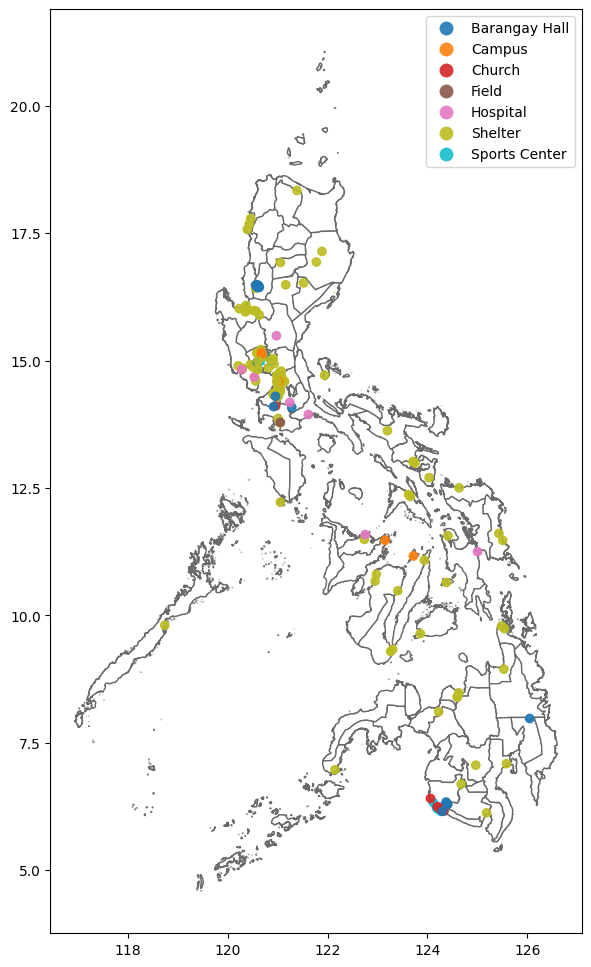

In [83]:
ax = ph_gdf.plot(figsize=(20, 12), color='white', edgecolor='dimgray')
ph_evacs_cleaned.plot(ax=ax, column='type', legend=True, alpha=0.9)